# Understanding LIME (Local Interpretable Model-agnostic Explainer)

## Todos

* [ ] Compare the output of my simplified LIME implementation to the output of the authors' original implementation


## References

Original LIME Paper

* ["Why Should I Trust You?" Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938.pdf)

Book Chapters

* https://ema.drwhy.ai/LIME.html#ref-imlRPackage
* https://christophm.github.io/interpretable-ml-book/lime.html

Implementations

* Python https://github.com/marcotcr/lime
* R https://github.com/thomasp85/lime

Other references

* https://arxiv.org/pdf/2006.12302.pdf
* https://homes.cs.washington.edu/~marcotcr/blog/lime/
* https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/
* https://cran.r-project.org/web/packages/lime/vignettes/Understanding_lime.html
* https://www.duo.uio.no/bitstream/handle/10852/74988/ideal19Final.pdf?sequence=1
* https://www.inovex.de/de/blog/lime-machine-learning-interpretability/




## Visual Intuition behind LIME

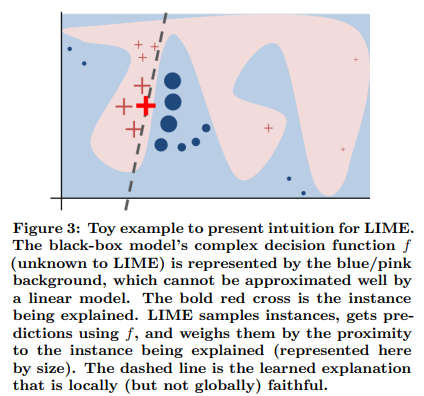

Source: https://arxiv.org/pdf/1602.04938.pdf

---

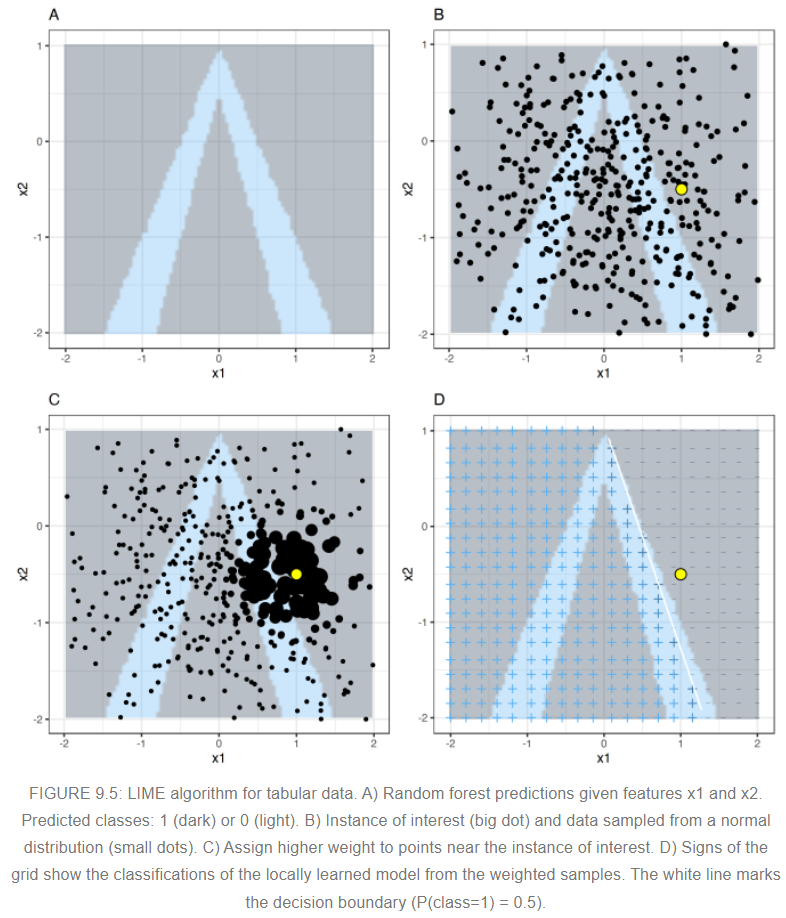

Source: https://christophm.github.io/interpretable-ml-book/lime.html

---

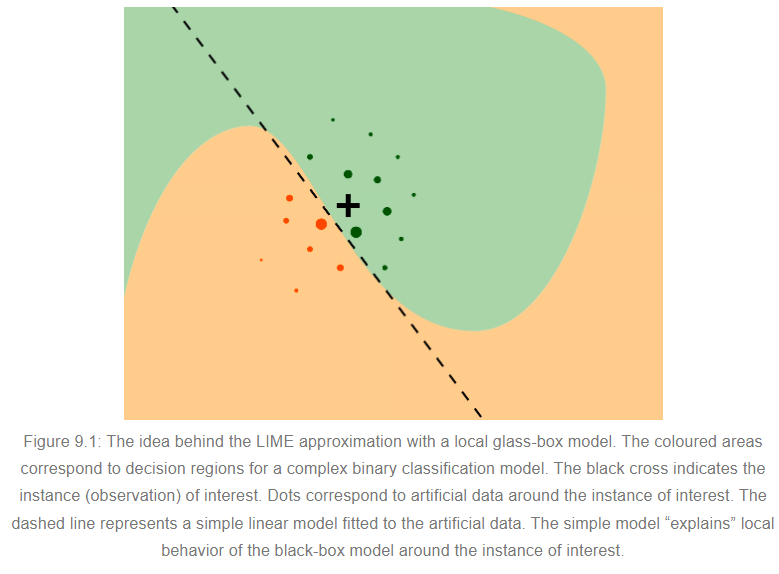

Source: https://ema.drwhy.ai/LIME.html#ref-imlRPackage

# Implementing a simplified LIME from scratch

The implementation works only for the simplest scenario: for tabular datasets containing only numerical features. 

## Step-by-Step


### Setup

* We have a dataset $X \in \mathbb{R}^{N\times d}$ containing $N$ observations of $d$ numerical features, and a corresponding vector of labels $y$ where $y_i\in\{0, 1\}$.
* We trained a black-box model $f()$ that learned to classify observations into class $0$ and class $1$.
* We have an instance $x_i \in \mathbb{R}^d$ with corresponding prediction $f(x_i)$ that we want to explain. We want to know which of the $d$ features influenced the prediction and how.

### Procedure

> (1) Determine an interpretable representation of the instance of interest. (2) Draw a sample by disturbing the interpretable representation. (3) Apply the original model to the perturbed instances. (4) Fit an interpretable model to proximity-weighted sampled instances and the predictions of the original model. (5) Use the interpretable model to draw conclusions about the relevance of each interpretable component [source](https://www.inovex.de/de/blog/lime-machine-learning-interpretability/)

To explain instance $x_i$, we train an interpretable glass-box classifier $g()$ (e.g. a regression model) that approximates the behavior of the black-box classifier $f()$ in the area near $x_i$ (in the "neighborhood" of $x_i$). How do we build such an imitating glass-box classifier?

* We need to create an artificial dataset that contains observations that are close to $x_i$. We need to cleverly sample observations in the neighborhood of $x_i$. We call the sampled dataset $Z \in \mathbb{R}^{M\times d}$. A sampled observation $z_j \in \mathbb{R}^d$ will be in the same "original" feature space as the to-be-explained observation $x_i$. The number of samples $M$ that we draw can be chosen freely.
* We want our glass-box classifier $g()$ to approximate the behavior of our black-box classifier $f()$ in the neighborhood of $x_i$. We have already sampled observations in the neighborhood of $x_i$ and stored them in dataset $Z$. We need to show our glass-box classifier some reference of how the black-box classifier behaves in the neighborhood of $x_i$, i.e. how it performs on dataset $Z$. In other words, we need to apply our black-box classifier onto dataset $Z$ and compute predictions $f(Z)$. Our glass-box classifier can then be trained on the dataset $Z$ with labels $f(Z)$.
* To get an even better approximation of the black-box classifier's behavior in the neighborhood of $x_i$, we calculate the distances of each observation $z_j \in Z$ to $x_i$. We convert these distances into measures of similarity (e.g., `similarity=1/distance`). These similarities between each pair $(z_j, x_i)$ are passed as a parameter of the `fit()` function to train the glass-box classifier. That is: `glass_box.fit(data=Z, labels=f(Z), weights=similarities)`
* Finished - we have trained an *interpretable* glass-box classifier $g()$ that approximates the behavior of the black-box classifier $f()$ in the near area of $x_i$, which is the observation whose prediction $f(x_i)$ we want to explain.
* We can use the glass-box classifier $g()$ to predict $x_i$, ie compute $g(x_i)$, and can use the model's interpretable parameters to explain which variables affect the prediction and how.

### Extension: Interpretable data spaces

The LIME paper suggests training the glass-box classifier on data that is transformed into a better interpretable vector space.
In our case, this practically means that we discretize all of our continuous features: We take a continuous feature, create bins according to some strategy (e.g. equally sized bins; bins based on quantiles. [Here's a nice graphic](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_strategies.html), and then create dummy variables for each bin, where the value 1 indicates that an observation's feature value falls into that bin. 

Note: Be careful of perfect multicollinearity, which can bias the interpretation of the parameters of an interpretable glass-box model. To avoid perfect multicollinearity, we can create $(k-1)$ dummy variables for a variable that we discretized into $k$ bins.

If we use interpretable data spaces, the procedure changes to the following:

* Given our to-be-explained observation $x_i$, generate samples around the neighborhood of $x_i$ and store them into a sampled dataset $Z \in \mathbb{R}^{M\times d}$ (same as we did before).
* Train a discretizer $d()$ on $X$. The discretizer learns to discretize the continuous features of $X$ into bins.
* Apply the discretizer to the sampled dataset $Z$ to get $Z'=d(Z)$. Note that $Z'$ will have only dummy variables as features.
* Compute $f(Z)$ to get the labels required to train our glass-box classifier
* Train the glass-box classifier $g()$ on dataset $Z'$ with labels $f(Z)$
* Explain how the black-box classifier predicted $x_i$ by first transforming $x_i$ into the interpretable feature space, ie computing $d(x_i)$, and then predicting $g(d(x_i))$ using our imitating glass-box classifier $g()$.

In [1]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Create a dataset with non-linearily separable classes

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)

df = pd.DataFrame(dict(x_1 = X[:, 0], x_2 = X[:, 1], label = y))
df.head()

,x_1,x_2,label
0,-0.847262,0.755684,0
1,0.224070,-0.014109,1
2,0.348765,-0.326086,1
3,1.849375,-0.120293,1
4,0.318809,0.946284,0


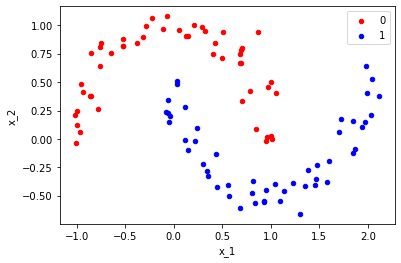

In [3]:
colors = {0: "red", 1: "blue"}
fig, ax = plt.subplots()
grouped = df.groupby("label")
for key, group in grouped:
    group.plot(ax=ax, kind="scatter", x="x_1", y="x_2", label=key, color=colors[key])
plt.show()

## Build a black box classifier 

Lime can explain individual predictions of any black box classifier. I use a Random Forest Classifier.

In [4]:
from sklearn.ensemble import RandomForestClassifier

blackbox_clf = RandomForestClassifier()
blackbox_clf.fit(X, y)

preds = blackbox_clf.predict(X)
probs = blackbox_clf.predict_proba(X)

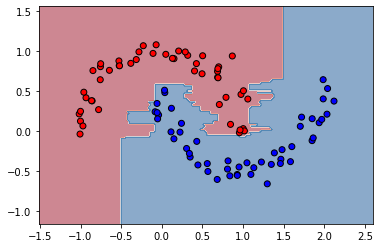

In [5]:
# Plot color-coded decision boundaries

# create mesh grid
step_size = 0.02
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, step_size), np.arange(x2_min, x2_max, step_size))

# predict classes of our grid
predsGrid = blackbox_clf.predict(np.c_[xx.ravel(), yy.ravel()])
predsGrid = predsGrid.reshape(xx.shape)
predsGrid[predsGrid >= 0.5] = 1
predsGrid[predsGrid < 0.5] = 0

from matplotlib.colors import ListedColormap
plt.contourf(xx, yy, predsGrid, cmap=plt.cm.RdBu, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")
plt.show()

## Select a single instance which we want to explain

We could just draw a random instance from our dataset $X$. However, I decided to pick an instance that is very close to the decision boundary. Such instance is one where our black box classifier is unsure about whether it belongs to class 0 or class 0.

In [6]:
# Select an instance that is close to the decision boundary, ie Pr(Y=1|x)~0.5
df["pred_label"] = preds
df["pred_proba"] = probs[:, 1]
df["confidence"] = abs(df.pred_proba - 0.5)
i = df.sort_values("confidence", ascending=True).index.tolist()[0]
x = X[i]

print(f"to-be-explained instance i={i}: {x}")

to-be-explained instance i=49: [ 0.95515313 -0.02154838]


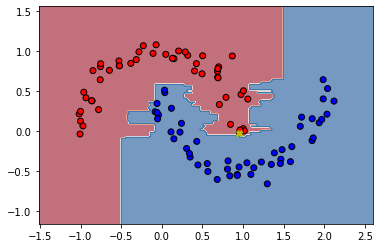

In [7]:
plt.contourf(xx, yy, predsGrid, cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")
plt.plot(x[0], x[1], "yX")
plt.show()

## Create samples around the to-be-explained instance x

Sampling observations in the neighborhood is a key part of LIME. There have been several sampling techniques suggested. As this is a tutorial, I decided to use the simplest one, which is also used in the [original LIME implementation](https://github.com/marcotcr/lime).

### Why do we create an artificial dataset when we could sample instances from our dataset?

There could be few observations in our dataset $X$ that are close to the to-be-explained instance $x$. If there are only few observations in $X$ that are in the neighborhood of $x$, then it's not possible to train a glass-box classifier that that approximates the behavior of the black-box classifier in the neighborhood of $x$ well enough.

Our goal is to train a glass-box classifier that approximates the behavior of the black-box classifier in the near neighborhood of the to-be-explained instance $x$. To do this, we need a dataset with many observations that are in the neighborhood of $x$.


In [8]:
def means_and_sdevs(X):
    """Calculates mean and standard deviation for each column of X"""
    means = np.mean(X, axis=0)
    sdevs = np.mean(X, axis=0)
    return means, sdevs

def generate_samples(x, n_samples, sdevs_of_features):
    """
    Generates a dataset of sampled observations close to the 
    to-be-explained instance x.
    """
    n_cols = len(means)
    Z = np.random.normal(0, 1, n_samples*n_cols).reshape(n_samples, n_cols)
    Z = Z * sdevs_of_features + x
    return Z

In [9]:
n_samples = 200
means, sdevs = means_and_sdevs(X)

Z = generate_samples(x, n_samples=n_samples, sdevs_of_features=sdevs)

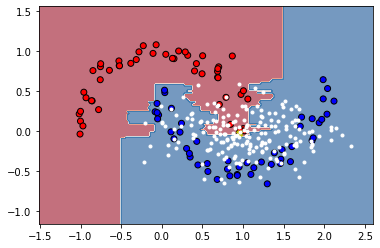

In [10]:
plt.contourf(xx, yy, predsGrid, cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]), edgecolors="k")
plt.plot(x[0], x[1], "yX")
plt.plot(Z[:, 0], Z[:, 1], "w.")
plt.show()

## Predict each sampled instance using the black box classifier

In [11]:
preds_samples = blackbox_clf.predict(Z)
preds_samples.shape

(200,)

## Create the dataset on which we train the glass (interpretable) classifier

The interpretable classifier is trained on a discretized dataset. Discretizing continuous variables makes an interpretation easier.

In [12]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=4, encode="onehot", strategy="uniform")
discretizer.fit(X)

X_glass = discretizer.transform(Z)
y_glass = preds_samples

## Calculate distance between each generated sample instance and the to-be-explained instance x

In [13]:
import scipy
def euclidean_dist(X, x):
    print(X.shape)
    print(x.shape)
    distances = scipy.spatial.distance.cdist(
        XA=X,
        XB=x.reshape(1, -1),
        metric="euclidean"
    )
    return distances.reshape(-1)

In [14]:
dists = euclidean_dist(Z, x)
similarities = 1/dists
similarities

(200, 2)
(2,)


array([  1.69683442,   3.11737026,   1.37356585,   1.91282497,
         1.69281234,   1.09964495,   3.23825314,   1.63829407,
         2.62178736,   2.87455642,   1.5761065 ,   3.05850242,
         4.20317788,   1.114147  ,   6.42944186,   6.24674984,
         2.94499205,   2.66246934,   1.64870462,   1.61384579,
         3.69680207,   1.56464384,   5.47064687,  23.81082601,
         1.09304053,   1.15176359,   2.94661263,   5.29519208,
         1.72765104,   7.04249314,   5.48240698,   1.42419026,
         2.7698317 ,   3.42320658,   2.04426852,   1.23779489,
         2.5057732 ,   4.18955467,   1.72223329,   1.44477724,
         3.15755347,   1.20974792,   5.54690576,   0.83663266,
         1.99464914,   1.63911346,   1.30471369,   2.05096256,
         1.64905411,   2.31400583,  13.54228944,   1.49947113,
         2.96204465,   3.39486596,   2.27675093,   1.11854191,
         1.46779441,  14.65883241,   2.72192995,   3.58388079,
        15.47682192,   6.05389047,   1.22724353,   1.41

## Train glass (interpretable) classifier

Here, I use logistic regression.

In [15]:
from sklearn.linear_model import LogisticRegression

glass_clf = LogisticRegression()
glass_clf.fit(X_glass, y_glass, sample_weight=similarities)
glass_clf_preds = glass_clf.predict(X_glass)

In [16]:
data_plt = pd.DataFrame(dict(x_1=Z[:, 0], x_2=Z[:, 1], label=y_glass, pred=glass_clf_preds))
data_plt.head()

,x_1,x_2,label,pred
0,1.526760,-0.165002,1,1
1,0.672731,0.130568,1,0
2,0.232383,0.065821,1,1
3,1.445725,-0.202230,1,1
4,1.150167,0.536067,1,0


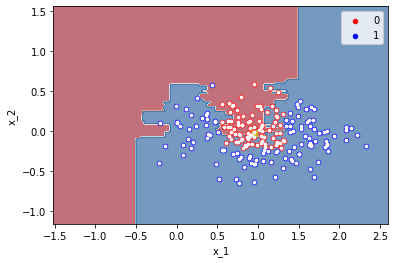

In [17]:
colors = {0: "red", 1: "blue"}
fig, ax = plt.subplots()
ax.contourf(xx, yy, predsGrid, cmap=plt.cm.RdBu, alpha=0.6)
ax.plot(x[0], x[1], "yX")
grouped = data_plt.groupby("pred")
for key, group in grouped:
    group.plot(ax=ax, kind="scatter", x="x_1", y="x_2", label=key, color=colors[key])
plt.plot(data_plt.x_1, data_plt.x_2, "w.")

The interpretable linear classifier approximates the black box classifier pretty well in the region near our to-be-explained instance $x$ (yellow cross).

## Explain the instance using the interpretable logistic regression model

In [18]:
print(glass_clf.coef_, glass_clf.intercept_)

score = glass_clf.intercept_ + x[0]*glass_clf.coef_[0, 0] + x[1]*glass_clf.coef_[0, 1]
prob = (1/(1+np.exp(-score)))
prob

[[ 0.          0.93341017 -2.66909672  1.73573508  2.73308825 -1.24624856
  -1.48679115  0.        ]] [3.14085638]


array([0.95774031])

In [19]:
def pretty_bins(discretizer):
    bin_names = []
    for j, x in enumerate(discretizer.bin_edges_):
        for i in range(1, len(x)-1):
            if i == 1:
                bin_name = f"var_{j}_[-inf, {round(x[i], 3)})"
            elif i < (len(x)-1):
                bin_name = f"var_{j}_[{round(x[i-1], 3)}, {round(x[i], 3)})"
            bin_names.append(bin_name)
            
        bin_name = f"var_{j}_[{round(x[-2], 3)}, +inf)"
        bin_names.append(bin_name)
    return bin_names

In [20]:
pretty_bins(discretizer)

['var_0_[-inf, -0.233)',
 'var_0_[-0.233, 0.551)',
 'var_0_[0.551, 1.335)',
 'var_0_[1.335, +inf)',
 'var_1_[-inf, -0.226)',
 'var_1_[-0.226, 0.209)',
 'var_1_[0.209, 0.644)',
 'var_1_[0.644, +inf)']

In [21]:
glass_clf.coef_[0]
bin_effects = glass_clf.coef_[0]

for bin_name, effect in zip(pretty_bins(discretizer), glass_clf.coef_[0]):
    print(f"{bin_name} \t Effect: {round(effect, 3)}")

var_0_[-inf, -0.233) 	 Effect: 0.0
var_0_[-0.233, 0.551) 	 Effect: 0.933
var_0_[0.551, 1.335) 	 Effect: -2.669
var_0_[1.335, +inf) 	 Effect: 1.736
var_1_[-inf, -0.226) 	 Effect: 2.733
var_1_[-0.226, 0.209) 	 Effect: -1.246
var_1_[0.209, 0.644) 	 Effect: -1.487
var_1_[0.644, +inf) 	 Effect: 0.0


Interpretation: If var ... is in bin ..., then the predicted odds of Y=1 are .... times the odds compared to reference category.

# Using LIME to explain a CNN trained to classify MNIST

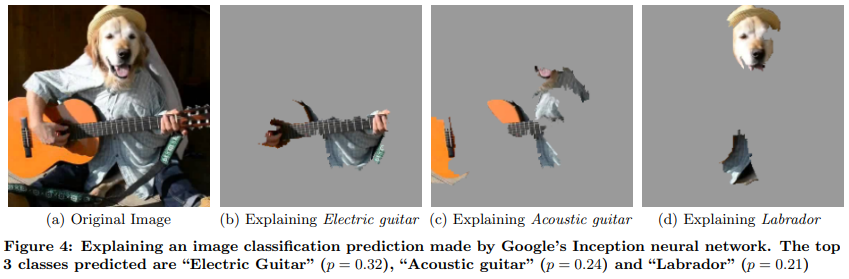

Source: LIME paper https://arxiv.org/pdf/1602.04938.pdf

## Intuition

We're interested in the question:

> Why did our model predict class $c\in \{0, 1, ..., C\}$?

We can rephrase this question into: *Which pixels made the model predict class $c$?*. If we only showed the pixels "with positive weight towards a specific class", then we would have an "intuition as to why the model would think that class may be present" [1].

* [1]: Original LIME Paper https://arxiv.org/pdf/1602.04938.pdf

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.datasets

from tqdm import trange

In [23]:
data_train = torchvision.datasets.MNIST(root="./mnist_data", train=True) # add download=True if you don't have it on disk
data_test = torchvision.datasets.MNIST(root="./mnist_data", train=False) # add download=True if you don't have it on disk
X_train, y_train = data_train.data, data_train.targets
X_test, y_test = data_test.data, data_test.targets

# normalize X_train to [0, 1]
X_train = X_train / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


In [24]:
# simple neural net
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        """
        Args:
            x (torch.array shape[batch_size, height, width]): batch of images
        Returns:
            out (torch.array shape[batch_size, n_classes]): unnormalized scores
        """
        x = x.flatten(start_dim=1)
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        return out
    
net = Net()
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(net.parameters(), lr=0.1)

100%|██████████████████████████████████████████| 200/200 [00:01<00:00, 179.38it/s]


accuracy: 0.9375


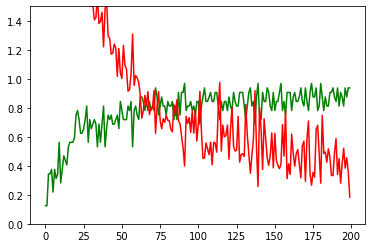

In [25]:
# training
BS = 32
EPOCHS = 200
accuracies = []
losses = []
for i in trange(EPOCHS):
    net.zero_grad()
    
    # draw random batch (mit Zurücklegen)
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp]
    y = y_train[samp]
    
    out = net(X)
    loss = crit(out, y)
    losses.append(loss.item())
    # accuracy
    preds = torch.argmax(out, dim=1)
    acc = (preds == y).float().mean()
    accuracies.append(acc)
    
    
    loss.backward()
    optim.step()
    
print(f"accuracy: {acc}")
plt.plot(accuracies, "g"); plt.plot(losses, "r")
plt.ylim(0, 1.5)
plt.show()

In [26]:
# evaluation
X = X_test.reshape((X_test.shape[0], -1)).float()
out = net(X)
preds = torch.argmax(out, dim=1).numpy()
acc = (preds == y_test.numpy()).mean()
print(acc)

0.8832


## Select a to-be-explained instance $x_i$


8256
torch.Size([28, 28])
tensor(7)


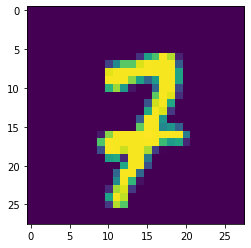

In [27]:
# random_state = np.random.RandomState(42)
# i = random_state.randint(0, X.shape[0])

img_id = np.random.randint(0, X.shape[0])
img = X_train[img_id]
img_label = y_train[img_id]

print(img_id)
print(img.shape)
print(img_label)

plt.imshow(img)
plt.show()

## Draw samples in the neighborhood of the to-be-explained instance $x_i$

> To develop a local-approximation glass-box model, we need new data points in the low-dimensional interpretable data space around the instance of interest

* perturbations of an image "could be created by randomly excluding some of the superpixels"

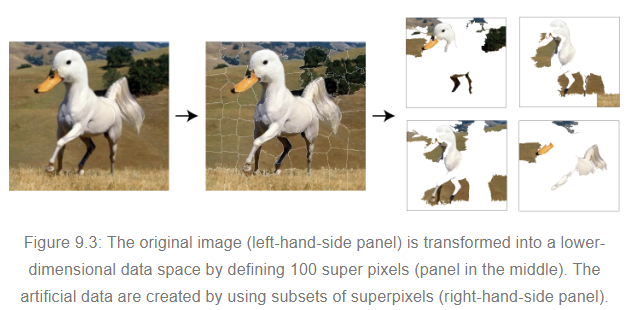

> LIME for images works differently than LIME for tabular data and text. Intuitively, it would not make much sense to perturb individual pixels, since many more than one pixel contribute to one class. Randomly changing individual pixels would probably not change the predictions by much. Therefore, variations of the images are created by segmenting the image into “superpixels” and turning superpixels off or on. Superpixels are interconnected pixels with similar colors and can be turned off by replacing each pixel with a user-defined color such as gray. The user can also specify a probability for turning off a superpixel in each permutation. [source](https://christophm.github.io/interpretable-ml-book/lime.html)

### Steps

1. Select an image $x_i$ whose predicted class label probabilities we want to have explained.
2. Segment image $x_i$ into "superpixels"
3. Generate a dataset containing samples (images) in the neighborhood of $x_i$. To draw a sample, we randomly turning superpixels off.

Notes:

* There are several image segmentation algorithms to create "superpixels". In the original LIME code, author's use Quickshift. Here's an [overview](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html) of segmentation algorithms implemented in scikit.

```
# LIME's default segmentation algorithm 
segmentation_fn = SegmentationAlgorithm(
    'quickshift',
    kernel_size=4,
    max_dist=200,
    ratio=0.2,
    random_seed=random_seed
)
```

In [28]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

In [29]:
# segmentation algorithms require the image to have 3 color channels
from skimage.color import gray2rgb

print(img.shape)
img = gray2rgb(img)
print(img.shape)

torch.Size([28, 28])
(28, 28, 3)


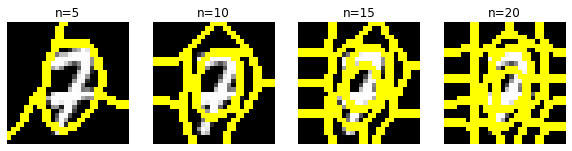

In [30]:
# segment to-be-explained image into superpixels using SLIC algorithm
test_n_segments = [5, 10, 15, 20]
fig, axs = plt.subplots(1, len(test_n_segments), figsize=(10, 5))
for n, ax in zip(test_n_segments, axs):
    masks = slic(img, n_segments = n, sigma = 4)
    ax.imshow(mark_boundaries(img, masks))
    ax.axis("off")
    ax.set_title(f"n={n}")
plt.show()

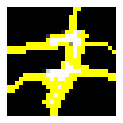

In [31]:
# segment image x_i into superpixels using QUICKSHIFT
from skimage.segmentation import quickshift

masks = quickshift(
    img,
    kernel_size=1.5,
    max_dist=100,
    ratio=0.3
)

plt.figure(figsize=(2,2))
plt.imshow(mark_boundaries(img, masks))
plt.axis("off")
plt.show()

In [32]:
print(masks.shape)
print(np.unique(masks))

(28, 28)
[0 1 2 3 4 5]


(28, 28)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


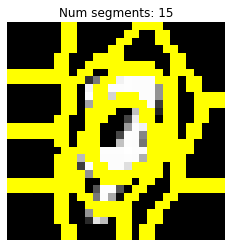

In [33]:
# i decide to use SLIC algorithm, just because you can specify the num of segments
n_segments = 15
masks = slic(img, n_segments = n_segments, sigma = 4)

print(masks.shape)
print(np.unique(masks))

plt.imshow(mark_boundaries(img, masks))
plt.axis("off")
plt.title(f"Num segments: {n_segments}")
plt.show()

In [34]:
segment_ids = np.unique(masks)
n_samples = 10

samples = []               # list of perturbed images
samples_off_segment_ids = []  # ids of deactivated segments (superpixels)
samples_on_segment_ids = []   # ids of activated segments (superpixels)
for i in range(n_samples):
    # how many superpixels should we deactivate?
    n_off_segments = np.random.randint(1, 10) 
    
    # which segments should we deactivate?
    off_segment_ids = np.random.choice(segment_ids, size=n_off_segments, replace=False)
    on_segment_ids = segment_ids[np.isin(segment_ids, off_segment_ids, invert=True)]
    
    sample = img.copy()
    
    # replace the pixels in every deactivated superpixel with gray (0.5) or black (0)
    for i in off_segment_ids:
        sample[masks == i] = 0
        
#     alternatively, we could replace the pixels in every deactived superpixel
#     with each superpixel's *mean* color.
#     for i in off_segment_ids:
#         sample[masks == i] = (
#             np.mean(sample[masks == i][:, 0]), # R
#             np.mean(sample[masks == i][:, 1]), # G
#             np.mean(sample[masks == i][:, 2])  # B
#         )
    samples.append(sample)
    samples_off_segment_ids.append(off_segment_ids)
    samples_on_segment_ids.append(on_segment_ids)

In [35]:
x = np.arange(10)
x.min()
x.max()

9

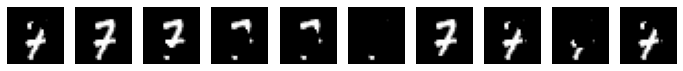

In [36]:
# sampled images
fig, axs = plt.subplots(1, n_samples, figsize=(12, 5))
for s, ax in zip(samples, axs):
    ax.imshow(s)
    ax.axis("off")

In [37]:
samples = np.array(samples)
samples.shape

(10, 28, 28, 3)

In [38]:
# our classifier was trained on grayscale images
from skimage.color import rgb2gray
samples = rgb2gray(samples)
samples.shape

(10, 28, 28)

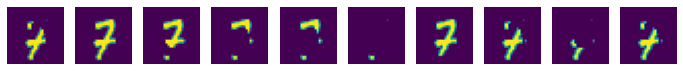

In [39]:
# plot sampled images that were converted back to grayscale
fig, axs = plt.subplots(1, n_samples, figsize=(12, 5))
for i, ax in enumerate(axs):
    s = samples[i, :, :]
    ax.imshow(s)
    ax.axis("off")

In [40]:
# classify sampled images using blackbox classifier
out = net(torch.Tensor(samples))
preds = torch.argmax(out, dim=1).numpy()
preds

array([4, 7, 7, 7, 7, 7, 7, 4, 6, 4], dtype=int64)

In [41]:
acc = (preds == img_label.numpy()).mean()
print(f"Accuracy of blackbox clf on our sampled dataset: {round(acc*100)}%")

Accuracy of blackbox clf on our sampled dataset: 60%


* what is the dataset for the glass-box classifier?
    * I'm not sure it's an image
    * I think it's superpixels...
    * Every superpixel is a feature
    * So the model learns: if superpixel 1=YES, 4=YES, 16=YES then predict 6
    * So a row might look like: data = [1, 0, 0, 1, 0, 0, 1], label = 6
    * Ie, each superpixel gets a dummy variable
    
Yeah, understood it right.

See here https://medium.com/swlh/immediately-understand-lime-for-ml-model-explanation-part-2-35e4fe9c8264

In [42]:
print(type(samples))
print(segment_ids)

<class 'numpy.ndarray'>
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [43]:
samples.shape

(10, 28, 28)

In [44]:
X_glass = np.zeros(shape=(n_samples, len(segment_ids)))

for i, on_segment_ids in enumerate(samples_on_segment_ids):
    on_segment_ids = on_segment_ids - 1 # segment_ids start from 1, but segment 1 corresponds to 0'th column
    for j in on_segment_ids:
        X_glass[i, j] = 1
        
# In the original LIME implementation, the first row stores
# the to-be-explained instance with all superpixels turned on.
X_glass[0, :] = np.ones(X_glass.shape[1])
    
X_glass

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.]])

In [45]:
y_glass = preds

# the first row stores the to-be-explained instance.
y_glass[0] = img_label

y_glass

array([7, 7, 7, 7, 7, 7, 7, 4, 6, 4], dtype=int64)

In [46]:
# TODO: calculate similarity of each sample in X_glass to the to-be-explained instance
similarities = np.ones(n_samples)

In [47]:
# train glassbox clf on sampled dataset Z
from sklearn.linear_model import Ridge, lars_path

easy_model = Ridge(
    alpha=1,
    fit_intercept=True
)

easy_model.fit(
    X_glass,
    y_glass,
    sample_weight=similarities
)

used_features = np.arange(X_glass.shape[1])

prediction_score = easy_model.score(
    X_glass[:, used_features],
    y_glass,
    sample_weight=similarities
)

In [48]:
prediction_score

0.9269590213541296

In [49]:
local_pred = easy_model.predict(X_glass[0, used_features].reshape(1, -1))
local_pred

array([6.53050158])

In [50]:
print('Intercept', easy_model.intercept_)
print('Coefs', easy_model.coef_)
print('Prediction_local', local_pred)

Intercept 6.116158152107616
Coefs [ 0.18085329 -0.32890539  0.48819417 -0.15566952 -0.20447383  0.37788016
  0.9966853  -0.22197151 -0.38337853  0.43990044 -0.10002981 -0.46464311
 -0.2626034  -0.11134809  0.37964536 -0.21579211]
Prediction_local [6.53050158]


In [51]:
# which features (superpixels) contribute most to the local prediction?
superpixels_effects = sorted(
    zip(used_features, easy_model.coef_),
    key=lambda x: np.abs(x[1]),
    reverse=True
)

In [52]:
masks.shape

(28, 28)

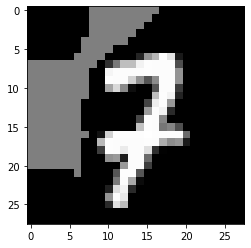

In [54]:
# show the top 3 contributing superpixels
top_segments = [x for (x,y) in superpixels_effects[:3]]

explainer = img.copy()
for i in top_segments:
    explainer[masks == i] = 0.5 # replace with black (=0)

plt.imshow(explainer)

## Same but with a pre-trained blackbox clf

In [57]:
import tensorflow as tf
import sys

In [58]:
model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [70]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

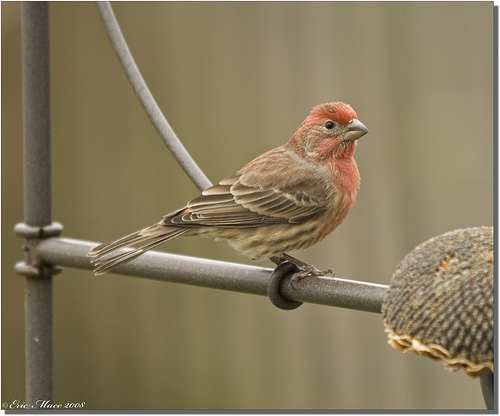

In [122]:
import os
from PIL import Image

img_path = "imagenet-samples"
img_name = "n01532829_house_finch.jfif"
img = Image.open(os.path.join(img_path, img_name))
img

In [123]:
# reshape image to match input layer dimensions of InceptionV3
w, h = 299, 299
img = img.resize((w, h), Image.ANTIALIAS) 

# convert image to tensor 
img = np.asarray(img)
img = img.reshape(1, *img.shape)
img = tf.convert_to_tensor(img, np.float32)
img.shape

TensorShape([1, 299, 299, 3])

In [124]:
# predict class of image
out = model(img)
pred = tf.argmax(out, axis=1).numpy()
pred

# 725 == "pitcher, ewer" https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

array([725], dtype=int64)

## Explain the prediction

In [125]:
# remove BS dimension
img = img.numpy().squeeze(axis=0)
img.shape

(299, 299, 3)

In [134]:
# normalize image
img = img / 255

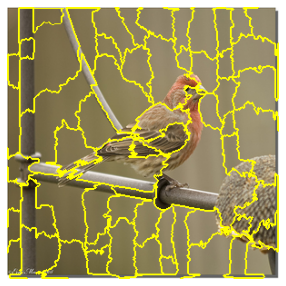

In [135]:
# segment image into superpixels
masks = quickshift(
    img,
    kernel_size=4,
    max_dist=200,
    ratio=0.4
)

plt.figure(figsize=(5,5))
plt.imshow(mark_boundaries(img, masks))
plt.axis("off")
plt.show()

In [242]:
segment_ids = np.unique(masks)
n_samples = 100

samples = []               # list of perturbed images
samples_off_segment_ids = []  # ids of deactivated segments (superpixels)
samples_on_segment_ids = []   # ids of activated segments (superpixels)
for i in range(n_samples):
    # How many superpixels to deactivate (between 20% - 80% of superpixels)
    n_off_segments = np.random.randint(len(segment_ids)*0.2, len(segment_ids)*0.8) 
    
    # which segments should we deactivate?
    off_segment_ids = np.random.choice(segment_ids, size=n_off_segments, replace=False)
    on_segment_ids = segment_ids[np.isin(segment_ids, off_segment_ids, invert=True)]
    
    sample = img.copy()
           
#     alternatively, we could replace the pixels in every deactived superpixel
#     with each superpixel's *mean* color.
    for i in off_segment_ids:
        sample[masks == i] = (
            np.mean(sample[masks == i][:, 0]), # R
            np.mean(sample[masks == i][:, 1]), # G
            np.mean(sample[masks == i][:, 2])  # B
        )

    samples.append(sample)
    samples_off_segment_ids.append(off_segment_ids)
    samples_on_segment_ids.append(on_segment_ids)

In [243]:
print(f"samples: {type(samples)} of length {len(samples)}")

samples: <class 'list'> of length 100


In [244]:
samples = np.array(samples)
samples.shape

(100, 299, 299, 3)

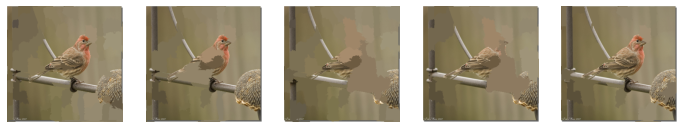

In [245]:
# plot sampled images that were converted back to grayscale
plot_n_samples = 5
fig, axs = plt.subplots(1, plot_n_samples, figsize=(12, 5))
for i, ax in enumerate(axs):
    s = samples[i, :, :]
    ax.imshow(s)
    ax.axis("off")

In [246]:
# create dataset for glass classifier
X_glass = np.zeros(shape=(n_samples, len(segment_ids)))

for i, on_segment_ids in enumerate(samples_on_segment_ids):
    on_segment_ids = on_segment_ids - 1 # segment_ids start from 1, but segment 1 corresponds to 0'th column
    for j in on_segment_ids:
        X_glass[i, j] = 1
        
# In the original LIME implementation, the first row stores
# the to-be-explained instance with all superpixels turned on.
X_glass[0, :] = np.ones(X_glass.shape[1])

In [247]:
print(f"X_glass: shape {X_glass.shape}")
print(f"X_glass has {X_glass.shape[0]} rows, one row for each sample")
print(f"X_glass has {X_glass.shape[1]} cols, where each column is a dummary variable for each superpixels")

X_glass: shape (100, 62)
X_glass has 100 rows, one row for each sample
X_glass has 62 cols, where each column is a dummary variable for each superpixels


In [248]:
# the labels are the predicted classes of the blackbox clf
samples = tf.convert_to_tensor(samples)
out = model(samples)
preds = tf.argmax(out, axis=1).numpy()

# In the original LIME implementation, the first row stores
# the to-be-explained instance with all superpixels turned on.
y_glass = preds
y_glass[0] = img_label

In [249]:
print(y_glass.shape)
y_glass

(100,)


array([  7,  11,  12,  12,  12,  12,  12,  12,  12,  12,  11,  11,  12,
        12,  12,  12,  11,  12,  12,  11,  12,  12,  11,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12, 733,  12,  12,  12,  12,  12,
        12,  18,  12,  11,  12,  94,  12,  18,  12,  12,  11,  11,  18,
        12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
       812,  12,  12,  12,  12,  12,  12,  18,  12,  12,  12,  12,  12,
        12,  12,  12,  12,  11,  18,  12,  12,  11,  12,  12,  12,  12,
        12,  12,  12,  11,  12,  12,  12,  12,  12], dtype=int64)

In [250]:
# train glassbox clf on sampled dataset Z
from sklearn.linear_model import Ridge, lars_path

easy_model = Ridge(
    alpha=1,
    fit_intercept=True
)

easy_model.fit(
    X_glass,
    y_glass
#     sample_weight=np.ones(n_samples)
)

used_features = np.arange(X_glass.shape[1])

prediction_score = easy_model.score(
    X_glass[:, used_features],
    y_glass
#     sample_weight=similarities
)

In [251]:
prediction_score

0.5413725731357841

In [252]:
local_pred = easy_model.predict(X_glass[0, used_features].reshape(1, -1))
local_pred

array([-24.17396945])

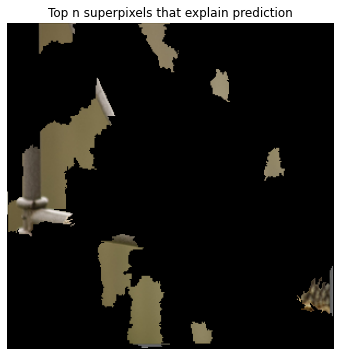

In [256]:
# which features (superpixels) contribute most to the local prediction?
superpixels_effects = sorted(
    zip(used_features, easy_model.coef_),
    key=lambda x: np.abs(x[1]),
    reverse=True
)

# show the top n contributing superpixels
top_n = 10
top_n_segments = [segment_id for (segment_id, effect_size) in superpixels_effects[:top_n]]
other_segments = segment_ids[np.isin(segment_ids, top_n_segments, invert=True)]

explainer = img.copy()
for i in other_segments:
    explainer[masks == i] = 0 # replace with black


plt.figure(figsize=(6, 6))
plt.imshow(explainer)
plt.axis("off")
plt.title("Top n superpixels that explain prediction")
plt.show()